# Multidimensional Double Well

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [3]:
import torch

import bgflow as bg
from bgflow.utils.types import assert_numpy
ctx = {'dtype': torch.float32, 'device': torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')}
ctx

{'dtype': torch.float32, 'device': device(type='cuda', index=0)}

In [4]:
#define the openmm system
class DoubleWellOpenMM():
    def __init__(self, model=bg.ModifiedWolfeQuapp(2)):
        '''
        Simulate a multidimensional double-well system using OpenMM.
        The given model provides the potential for the first 3 dof
        and the scale for the remaining Gaussian ones.
        Since all degrees of freedom but the firts two are uncoupled, 
        we use N particles in 3D instead of one particle in dim dimensions.
        '''
        dim = model.dim
        n_particles = 1 + (dim - 1) // 3
        partial_dim = dim % 3
        
        system = openmm.System()
        
        #first particle feels nontrivial potential
        model_potential = openmm.CustomExternalForce(model.potential_str)
        model_potential.addParticle(0)
        system.addParticle(1.0)
        system.addForce(model_potential)
        #other particles feel an harmonic potential
        if dim > 3:
            normal_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*(x^2+y^2+z^2)')
            for i in range(1, n_particles-bool(partial_dim)):
                normal_potential.addParticle(i)
                system.addParticle(1.0)
            system.addForce(normal_potential)
            #do not add a potential to the left over MD dimensions
            if partial_dim > 0:
                if partial_dim == 1:
                    dof = 'x^2'
                elif partial_dim == 2:
                    dof = '(x^2+y^2)'
                else:
                    assert False
                partial_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*{dof}')
                partial_potential.addParticle(n_particles-1)
                system.addParticle(1.0)
                system.addForce(partial_potential)
        
        #some arbitrary initial positions
        init_posA = np.array([[-1.5, 0.7, 0]]) #basin A
        init_posB = np.array([[2, -1.0, 0]]) #basin B
        if dim > 3:
            init_posA = np.append(init_posA, [0.0]*((n_particles-1)*3)).reshape(-1, 3)
            init_posB = np.append(init_posB, [0.0]*((n_particles-1)*3)).reshape(-1, 3)
        
        #properties:
        self.dim = dim #intrinsic dimension
        self.MD_dim = 3 * n_particles #MD dimension (multiple of 3), MD_dim >= dim
        
        self.system = system
        self.topology = openmm.app.topology.Topology()
        
        self.positions = init_posA
        self.pos_basinA = init_posA
        self.pos_basinB = init_posB

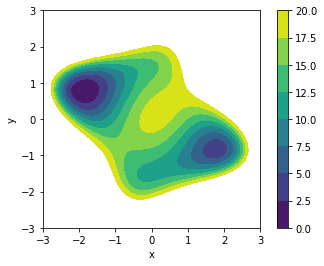

In [5]:
#some plotting functions
model2D = bg.ModifiedWolfeQuapp(2)
nbins = 101
x_bins = np.linspace(-3, 3, nbins)
y_bins = x_bins
XY = np.array(np.meshgrid(x_bins, y_bins))
DoubleWellXY = model2D.energy(torch.as_tensor(XY.T).reshape(nbins**2,2)).view(nbins, nbins).cpu().numpy().T

FES = np.zeros(len(x_bins))
for i in range(len(x_bins)):
    FES[i] = -np.logaddexp.reduce(-DoubleWellXY[:,i])
FES -= min(FES)

def plot_doublewell(traj=None, traj2=None, grid=False):
    levels = np.linspace(0,20,9)
    
    plt.contourf(XY[0], XY[1], DoubleWellXY, levels)
    plt.colorbar()
    plt.gca().set_box_aspect(1)
    plt.xlabel('x')
    plt.ylabel('y')
    if grid:
        plt.grid(linestyle='dashed')
    if traj is not None:
        xy_samples = assert_numpy(traj).reshape(len(traj),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '.r')
    if traj2 is not None:
        xy_samples = assert_numpy(traj2).reshape(len(traj2),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '+m')
    plt.show()
    
def plot_fes(data, temp=1/kB, bins='auto', w=None, show=True):
    x_samples = assert_numpy(data)
    beta = 1/(temp*kB)
    FES_t = [-np.logaddexp.reduce(-beta*DoubleWellXY[:,i]) for i in range(len(x_bins))]
    FES_t -= min(FES_t)
    plt.plot(x_bins, FES_t, '--', label='reference')
    if w is not None and bins == 'auto':
        bins = 50
    hist, edges = np.histogram(x_samples, bins=bins, weights=w)
    fes_estimate = -np.log(np.where(hist!=0, hist/hist.max(), np.nan))
    xrange = edges[:-1]+(edges[1]-edges[0])/2
    plt.plot(xrange, fes_estimate, label='estimate')
    plt.xlabel('x')
    plt.ylabel('FES')
    plt.ylim(0, FES_t[-1])
    plt.xlim(x_bins[0], x_bins[-1])
    plt.legend()
    if show:
        plt.show()
    fes_estimate[np.isnan(fes_estimate)] = 1000
    
    print(f'ref DeltaF: {np.logaddexp.reduce(-FES_t[x_bins<0])-np.logaddexp.reduce(-FES_t[x_bins>0]):g} [kBT]')
    print(f'    DeltaF: {np.logaddexp.reduce(-fes_estimate[xrange<0])-np.logaddexp.reduce(-fes_estimate[xrange>0]):g} [kBT]')

plot_doublewell()

## Get MD samples
To save time we run MD with the highest dimension, then we can mask the data to do the experiment at any lower dim using the same MD data

In [21]:
base_dim = 2**12
T_low = 1 / kB
T_high = 5 / kB

modelMD = DoubleWellOpenMM(bg.ModifiedWolfeQuapp(base_dim))

modelMD.dim, modelMD.MD_dim

(4096, 4098)

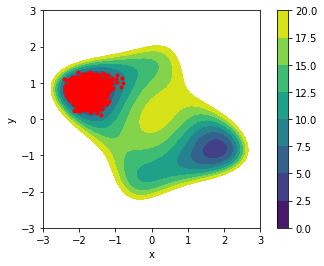

CPU times: user 1min 14s, sys: 3.83 s, total: 1min 17s
Wall time: 1min 13s


In [7]:
%%time
#sample target

pace = 100
n_iter = 10_000
n_equil = 100

integrator = openmm.LangevinMiddleIntegrator(T_low*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate
simulation.step(pace*n_equil)

#run MD
data = np.full((n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[:n+1])
    print(f'sampling...  {n/n_iter:.1%}', end='\r')

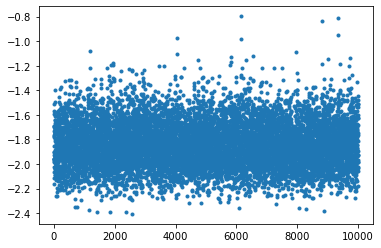

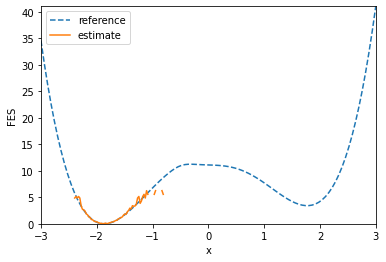

ref DeltaF: 3.31506 [kBT]
    DeltaF: inf [kBT]


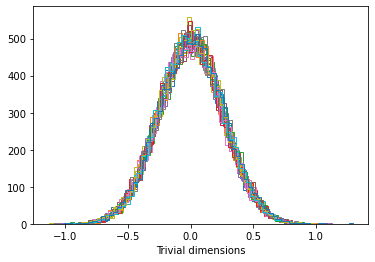

In [8]:
plt.plot(data[:,0,0], '.')
plt.show()
plot_fes(data[:,0,0], T_low)

plt.hist(data[:,0,2], bins='auto', histtype='step')
for j in range(min(10, (base_dim-1)//3)):
    for i in range(3):
        plt.hist(data[:,1+j,i], bins='auto', histtype='step')
plt.xlabel('Trivial dimensions')
plt.show()

In [9]:
target_data = torch.as_tensor(data.reshape(len(data),-1)[:,:base_dim], **ctx)
target_data.shape

torch.Size([10000, 4096])

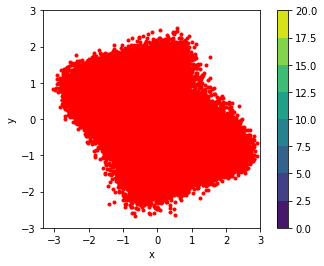

CPU times: user 8min 53s, sys: 27.9 s, total: 9min 21s
Wall time: 8min 50s


In [10]:
%%time
#sample prior

# pace = 100
len_training = 5*100*2**7
n_iter = len_training + 10_000

integrator = openmm.LangevinMiddleIntegrator(T_high*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate
simulation.step(pace*n_equil)

#run MD
data = np.full((n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[:n+1])
    print(f'sampling...  {n/n_iter:.1%}', end='\r')

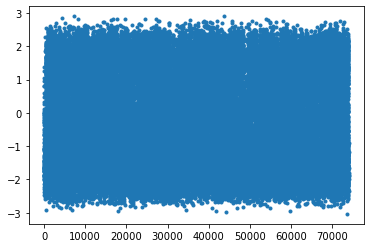

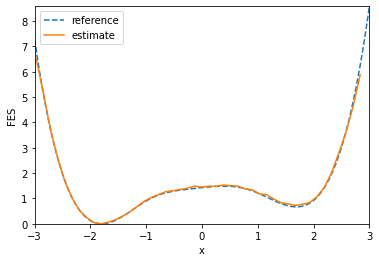

ref DeltaF: 0.52824 [kBT]
    DeltaF: 0.581587 [kBT]


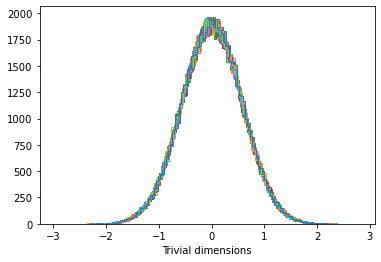

In [11]:
plt.plot(data[:,0,0], '.')
plt.show()
plot_fes(data[:,0,0], T_high)

plt.hist(data[:,0,2], bins='auto', histtype='step')
for j in range(min(10, (base_dim-1)//3)):
    for i in range(3):
        plt.hist(data[:,1+j,i], bins='auto', histtype='step')
plt.xlabel('Trivial dimensions')
plt.show()

In [12]:
prior_data = torch.as_tensor(data.reshape(len(data),-1)[:len_training,:base_dim], **ctx)
testing_data = torch.as_tensor(data.reshape(len(data),-1)[len_training:,:base_dim], **ctx)
prior_data.shape, testing_data.shape

(torch.Size([64000, 4096]), torch.Size([10000, 4096]))

## Setup the flow

In [13]:
dim = base_dim
store_energies = False

assert dim <= base_dim, 'run MD with larger base_dim'

model = bg.ModifiedWolfeQuapp(dim)
target = bg.ModifiedWolfeQuapp(dim, beta=1/(T_low*kB)).to(**ctx)
prior = bg.CustomDistribution(
    bg.ModifiedWolfeQuapp(dim, beta=1/(T_high*kB)).to(**ctx), 
    bg.DataSetSampler(prior_data[:,:dim], shuffle=True, **ctx)
)

print(f'N = {dim}')

N = 4096


In [14]:
#stuff to visualize the latent space
edge = 3.5
latentGrid = np.linspace(-edge, edge, nbins)
latentX, latentY = np.meshgrid(latentGrid, latentGrid)
if dim > 2:
    latentXY = torch.as_tensor(np.c_[latentX.flatten(),latentY.flatten(),np.zeros((nbins**2, dim-2))], **ctx)
else:
    latentXY = torch.as_tensor(np.c_[(latentX.flatten(),latentY.flatten())], **ctx)

def plot_latent(flow, traj=None, traj2=None, vmax=30):
    with torch.no_grad():
        mappedMesh, dlogp = flow(latentXY)
        mappedDoubleWellXY = assert_numpy((target.energy(mappedMesh)-dlogp).view(nbins,nbins))
    plt.imshow(mappedDoubleWellXY-mappedDoubleWellXY.min(), vmax=vmax, origin='lower', extent=(-edge,edge,-edge,edge))
    plt.colorbar()
    plt.gca().set_box_aspect(1)
    plt.xlabel('latent x')
    plt.ylabel('latent y')
    if traj is not None:
        samples = assert_numpy(traj).reshape(len(traj),-1)[:,:2]
        plt.plot(samples[:,0], samples[:,1], '.r')
    if traj2 is not None:
        samples = assert_numpy(traj2).reshape(len(traj2),-1)[:,:2]
        plt.plot(samples[:,0], samples[:,1], '.m')
    plt.show()

#define a grid in latent
grid = np.linspace(-edge, edge, 20)
myX, myY = np.meshgrid(grid,grid)
if dim > 2:
    xy = torch.as_tensor(np.c_[myX.flatten(), myY.flatten(), np.zeros((len(myX.flatten()), dim-2))], **ctx)
else:
    xy = torch.as_tensor(np.c_[myX.flatten(), myY.flatten()], **ctx)
latentMask = assert_numpy(prior.energy(xy).view(-1))<5

In [57]:
#setup the flow
n_coupling = 1
n_splitting = 2
zero_init = True
hidden_nodes = [2**7, 2**7]

assert dim % n_splitting == 0, 'change the splitting scheme to use this dim'
nodes = [dim-dim//n_splitting, *hidden_nodes, dim//n_splitting]
splitting = [dim//n_splitting] * n_splitting
layers = [bg.SplitFlow(*splitting)]
for _ in range(n_coupling):
    for i in range(n_splitting):
        transformer = bg.AffineTransformer(
            shift_transformation=bg.DenseNet(nodes, activation=torch.nn.ReLU()),
            scale_transformation=bg.DenseNet(nodes, activation=torch.nn.ReLU())
        )
        layers.append(bg.CouplingFlow(transformer, transformed_indices=[i], cond_indices=[j for j in range(n_splitting) if j != i]))
layers.append(bg.MergeFlow(*splitting))
flow = bg.SequentialFlow(layers).to(**ctx)
generator = bg.BoltzmannGenerator(prior, flow, target)

tot_param = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Number of Parameters: {tot_param:_}")

if zero_init:
    for p in flow.parameters():
        p.data.fill_(0)
with torch.no_grad():
    print(f'Delta max: {(xy - flow(xy)[0]).abs().max().item():g}')
    print(f'dlogp max: {flow(xy)[1].abs().max().item():g}')

Number of Parameters: 2_171_906
Setting parameters to zero
Delta max: 0
dlogp max: 0


In [58]:
#setup training
batchsize = 2**7
w_likelihood = 0

optimizer = torch.optim.Adam(generator.parameters(), lr=1e-2)
trainer = bg.KLTrainer(generator, optimizer)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1/10, verbose=True)
prior._delegate_sampler.reshuffle_()
if w_likelihood == 0:
    print('energy training only')

Adjusting learning rate of group 0 to 1.0000e-02.
energy training only


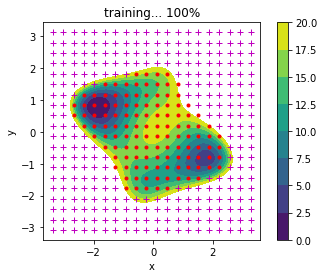

CPU times: user 29.3 s, sys: 7.71 s, total: 37 s
Wall time: 21.7 s


In [59]:
%%time
with torch.no_grad():
    mapped_xy = flow(xy)[0]
    plot_doublewell(mapped_xy[latentMask], mapped_xy[~latentMask])

stride = 5
n_iter = 100
#run energy training
for i in range(n_iter):
    if i % (n_iter//4) == 0 and i != 0:
        scheduler.step()
    trainer.train(stride, target_data[:,:dim], batchsize=batchsize, w_likelihood=w_likelihood)
    clear_output(wait=True)
    plt.title(f'training... {(i+1)/(n_iter):.0%}')
    with torch.no_grad():
        mapped_xy = flow(xy)[0]
        plot_doublewell(mapped_xy[latentMask], mapped_xy[~latentMask])

KLD from 10260.8 to 5354.75
NLL from 408.261 to -1250.71


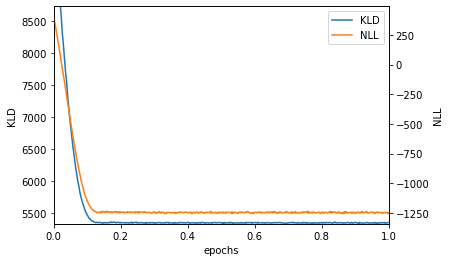

In [60]:
fig, ax = plt.subplots()
report = trainer.reporter._raw[0]
epochs = np.linspace(0, len_training/len(report)/batchsize, len(report))
line1, = ax.plot(epochs, report, label='KLD')
ax.set_ylim(min(report), np.percentile(report,98))
ax.set_ylabel('KLD')
ax.set_xlim(epochs[0], epochs[-1])
ax.set_xlabel('epochs')
print(f'KLD from {report[0]:g} to {report[-1]:g}')
if len(trainer.reporter._raw) == 2:
    report = trainer.reporter._raw[1]
    ax2 = ax.twinx()
    ax2.plot([], []) #fixes color
    line2, = ax2.plot(epochs, report, label='NLL')
    ax2.set_ylabel('NLL')
    print(f'NLL from {report[0]:g} to {report[-1]:g}')
    plt.legend([line1, line2], ['KLD', 'NLL'])
plt.show()

## Visualize results

PRIOR
Sampling efficiency: 0.01%
ESS: 1


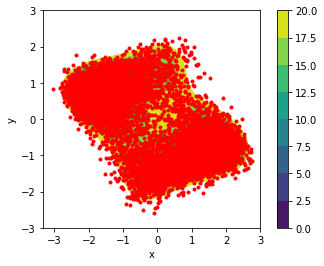

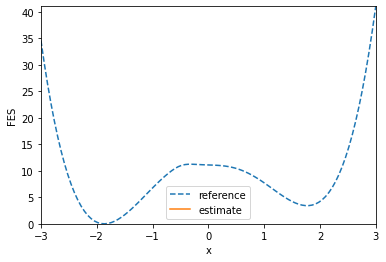

ref DeltaF: 3.31506 [kBT]
    DeltaF: 41.7129 [kBT]

BOLTZMANN GENERATOR
Sampling efficiency: 10.84%
ESS: 1083.89


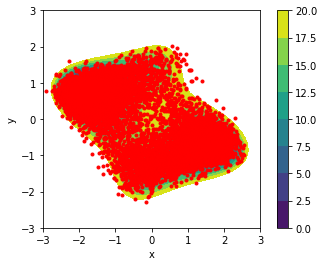

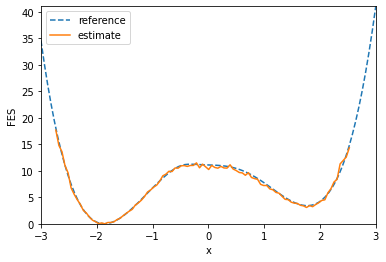

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.1471 [kBT]


In [61]:
# n_samples = len(testing_data)
prior._delegate_sampler.reshuffle_()
with torch.no_grad():
    print('PRIOR')
    # samples = torch.cat((prior_data, testing_data))[:,:dim]
    prior_samples = testing_data[:,:dim]
    prior_ene = prior.energy(prior_samples)
    logw = prior_ene - target.energy(prior_samples)
    logw -= logw.max()
    print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')
    print(f'ESS: {bg.effective_sample_size(logw).item():g}')
    plot_doublewell(prior_samples)
    plot_fes(prior_samples[:,0].cpu(), T_low, w=logw.exp().view(-1).cpu(), bins=100)
    
    print('\nBOLTZMANN GENERATOR')
    # samples, logw = generator.sample(n_samples, with_log_weights=True)
    mapped_samples, dlogp = flow(prior_samples)
    logw = prior_ene + dlogp - target.energy(mapped_samples)
    logw -= logw.max()
    print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')
    print(f'ESS: {bg.effective_sample_size(logw).item():g}')
    plot_doublewell(mapped_samples)
    plot_fes(mapped_samples[:,0].cpu(), T_low, w=logw.exp().view(-1).cpu(), bins=100)

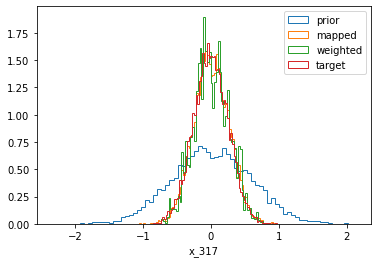

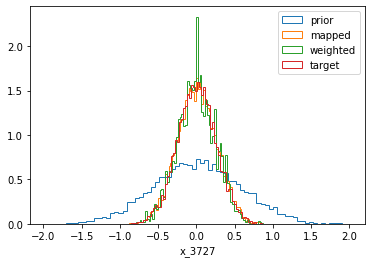

In [76]:
#1D marginal
hist_opt = {'bins': 75, 'histtype': 'step', 'density': True}
for i in [np.random.randint(0, dim), np.random.randint(0, dim)]:
    plt.hist(prior_samples[:,i].cpu(), **hist_opt, label='prior')
    plt.hist(mapped_samples[:,i].cpu(), **hist_opt, label='mapped')
    plt.hist(mapped_samples[:,i].cpu(), **hist_opt, weights=logw.exp().view(-1).cpu(), label='weighted')
    plt.hist(target_data[:,i].cpu(), **hist_opt, label='target')
    plt.xlabel(f'x_{1+i}')
    plt.legend()
    plt.show()

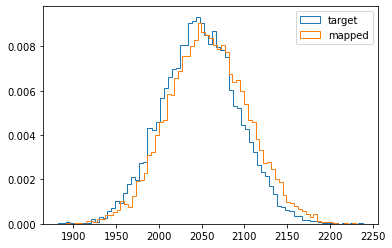

In [63]:
#energy
hist_opt = {'bins': 75, 'histtype': 'step', 'density': True}
plt.hist(target.energy(target_data[:,:dim]).view(-1).cpu(), **hist_opt, label='target')
# plt.hist(target.energy(prior_samples).view(-1).cpu(), **hist_opt, label='prior')
plt.hist(target.energy(mapped_samples).view(-1).cpu(), **hist_opt, label='mapped')
# plt.hist(target.energy(mapped_samples).view(-1).cpu(), weights=logw.exp().view(-1).cpu(), **hist_opt, label='reweighted')
plt.xlabel('potential energy')
plt.legend()
plt.show()

#store them
energies = [assert_numpy(target.energy(target_data[:,:dim]).view(-1)), 
            assert_numpy(target.energy(mapped_samples).view(-1)), 
            assert_numpy(target.energy(prior_samples).view(-1))
           ]
np.save(f'DoubleWell{dim}-NFenergies.pny', energies)

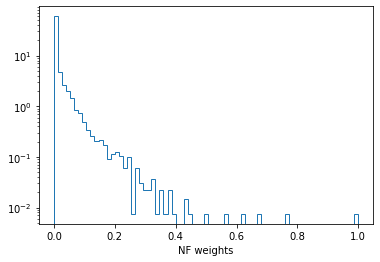

Sampling efficiency: 10.84%


In [83]:
#weights
plt.hist(logw.exp().view(-1).cpu().numpy(), **hist_opt)
plt.yscale('log')
plt.xlabel('NF weights')
plt.show()
print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')

## LREX

In [85]:
%%time

pace = 100
n_iter = 10_000
mc_stride = 1

n_replicas = 2
temperatures = [T_low, T_high]
modelMD = DoubleWellOpenMM(model)
initial_pos = [modelMD.positions] * n_replicas
integrator = []
simulation = []
for i in range(n_replicas):
    integrator.append(openmm.LangevinMiddleIntegrator(temperatures[i]*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond))
    simulation.append(openmm.app.Simulation(modelMD.topology, modelMD.system, integrator[i]))
    simulation[i].context.setPositions(initial_pos[i])

n_equil = 100
for i in range(n_replicas):
    print('equilibrating...', i, end='\r')
    simulation[i].step(n_equil*pace)

CPU times: user 288 ms, sys: 117 ms, total: 406 ms
Wall time: 439 ms


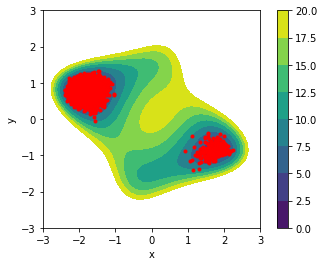

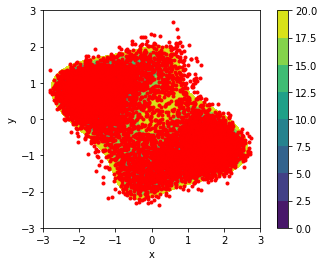

CPU times: user 3min 23s, sys: 10.4 s, total: 3min 33s
Wall time: 3min 21s


In [87]:
%%time

data = np.full((n_replicas, n_iter, *modelMD.positions.shape), np.nan)
is_swapped = np.full(n_iter, False)
for n in range(n_iter):
    for i in range(n_replicas):
        simulation[i].step(pace)
        data[i][n] = simulation[i].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometer)
    if n % mc_stride == 0:           
        with torch.no_grad():
            z_h = torch.as_tensor(data[1][n], **ctx).view(1, modelMD.MD_dim)[:,:dim]
            x_h, dlogp_h = flow(z_h, inverse=False)
            logw_h = prior.energy(z_h) + dlogp_h - target.energy(x_h)

            x_l = torch.as_tensor(data[0][n], **ctx).view(1, modelMD.MD_dim)[:,:dim]
            z_l, dlogp_l = flow(x_l, inverse=True)
            logw_l = target.energy(x_l) + dlogp_l - prior.energy(z_l)
        
        delta_energy = -(logw_h + logw_l).item()
        if delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy):
            is_swapped[n] = True
            simulation[0].context.setPositions(np.resize(assert_numpy(x_h), modelMD.positions.shape))
            simulation[0].context.setVelocitiesToTemperature(temperatures[0])
            simulation[1].context.setPositions(np.resize(assert_numpy(z_l), modelMD.positions.shape))
            simulation[1].context.setVelocitiesToTemperature(temperatures[1])
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[0,:n+1,:])
        plot_doublewell(data[1,:n+1,:])
    print(f'sampling...  {(n+1)/n_iter:.1%}, accepted: {mc_stride*is_swapped[:n+1].sum()/(n+1):.2%}', end='\r')

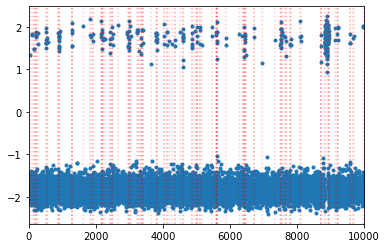

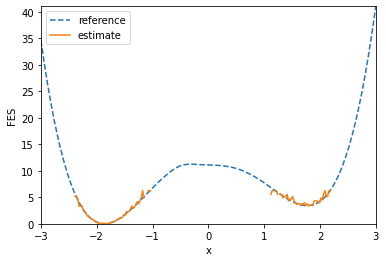

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.46925 [kBT]


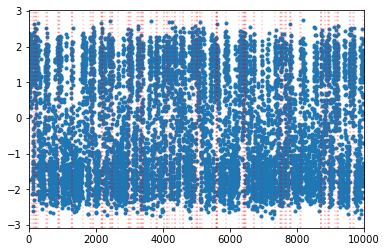

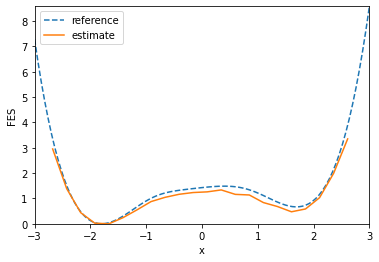

ref DeltaF: 0.52824 [kBT]
    DeltaF: 0.391734 [kBT]


In [88]:
diff = np.array(data[0, :, 0, 0]*data[1, :, 0, 0] < 0)
for i in range(n_replicas):
    plt.plot(data[i, :, 0, 0], ".")
    for sw in np.where(is_swapped)[0]:
        if diff[sw]: #highlight only useful exchanges
            plt.axvline(sw, c='r', ls=':', alpha=.1)
    plt.xlim(0, n_iter)
    plt.show()
    plot_fes(data[i, :, 0, 0], temperatures[i])
    plt.show()

Fraction of accepted exchanges: 14.82%
  of which between different states: 16.33%
Fraction of accepted exchanges between different states: 2.42%


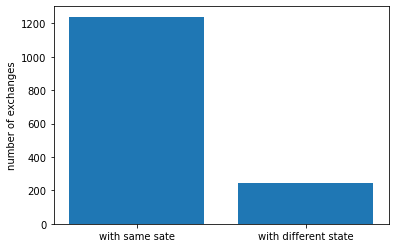

In [89]:
assert mc_stride == 1
diff_sw = diff[is_swapped].sum()
plt.bar(
    ["with same sate", "with different state"], [is_swapped.sum()-diff_sw, diff_sw]
)
plt.ylabel("number of exchanges")

# print('Tot exchanges with lowest prob state:', (state_h == 7).sum())
print(f"Fraction of accepted exchanges: {is_swapped.sum()/len(is_swapped):.2%}")
print(f"  of which between different states: {diff_sw/is_swapped.sum():.2%}")
print(f"Fraction of accepted exchanges between different states: {diff_sw/len(is_swapped):.2%}")

In [ ]:
np.save(f'dw-LREX-N{dim}', data[0,:,0, 0])